In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, dirichlet, norm, multivariate_normal
import warnings
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Data

We generate data for 3-G toy task from the paper. It has 3 classes, occurring independently of each other. Each class has $\tau$ following a normal distribution. Therefore, it is important to learn the evolution of probabilities over time and not only the most likely next event.

In [2]:
class Data:
    def __init__(self, N=1000):
        self.data = self.generate(N)
        self.train = self.data[:int(0.6 * N)]
        self.val = self.data[int(0.6 * N):int(0.8 * N)]
        self.test = self.data[int(0.8 * N):]
        
    def get_batch(self, size, seq_len):
        start = np.random.randint(0, self.train.shape[0] - seq_len - 1, size)
        sample = np.array([self.train[s:(s + seq_len + 1)] for s in start])

        x, tx = sample[:,:-1,0], sample[:,:-1,1]
        y, ty = sample[:,1:,0], sample[:,1:,1]
        s = np.ones(size) * seq_len
        
        return x, tx, y, ty, s
        
    def generate(self, N):
        np.random.seed(123)
        data = np.zeros((N, 2))
        for i in range(N):
            i_class = np.random.choice(3, 1)[0]
            time = np.random.normal(i_class + 1, .5)
            while time <= 0:
                time = np.random.normal(i_class + 1, 1.)
            data[i, 0] = i_class
            data[i, 1] = time
        data[:, 1] = (data[:, 1] - data[:, 1].min()) / data[:, 1].ptp()
        return data

def get_shape(x):
    static = x.get_shape().as_list()
    shape = tf.shape(x)
    return [static[i] or shape[i] for i in range(len(static))]

In [3]:
d = Data()

In the following plot we can see how is $\tau$ distributed for each class.

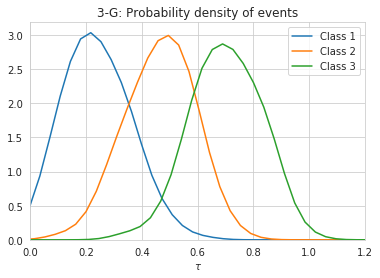

In [4]:
sns.kdeplot(d.train[np.where(d.train[:,0] == 0)[0], 1], bw=0.5, label='Class 1')
sns.kdeplot(d.train[np.where(d.train[:,0] == 1)[0], 1], bw=0.5, label='Class 2')
sns.kdeplot(d.train[np.where(d.train[:,0] == 2)[0], 1], bw=0.5, label='Class 3')
plt.xlim([0, 1.2])
plt.xlabel(r'$\tau$')
plt.legend()
plt.title('3-G: Probability density of events')
plt.show()

# Logistic Normal via a Weighted Gaussian Process (LN-WGP)

In [5]:
class GaussianProcess:
    def __init__(self, n_classes, dim, points=3, lr=0.001, alpha=1e-2, beta=1e-2, l2=1e-4, cell='gru'):
        self.n_classes = n_classes
        self.dim = dim
        self.points = points
        self.alpha = alpha
        self.beta = beta
        self.cell = cell

        self.x = tf.placeholder(tf.int32, [None, None], 'x')
        self.tx = tf.placeholder(tf.float32, [None, None], 'tx')
        self.y = tf.placeholder(tf.int32, [None, None], 'y')
        self.ty = tf.placeholder(tf.float32, [None, None], 'ty')
        self.s = tf.placeholder(tf.int32, [None], 'sequence-length')

        self.sigma = tf.get_variable('sigma-x', [], tf.float32)
        self.epsilon = 0.1

        self.h = self.RNN(self.x, self.tx, self.s)
        self.h = tf.identity(self.h, name='hidden')

        self.t_sample, self.y_sample, self.w = self.get_points(self.h)
        self.logits, self.logits_sigma = self.GP(self.t_sample, self.y_sample, self.ty, self.w)
        self.logits = tf.identity(self.logits, name='logits')
        self.logits_sigma = tf.identity(self.logits_sigma, name='logits_sigma')

        self.py = tf.nn.softmax(self.logits, -1, name='py')
        self.y_hat = tf.argmax(self.logits, -1, name='y-hat')

        e_k = tf.reduce_sum(tf.exp(self.logits + self.logits_sigma / 2), -1)
        var_k = tf.log(tf.reduce_sum((tf.exp(self.logits_sigma + 1)) * tf.exp(2 * self.logits + self.logits_sigma), -1))
        mu_k = tf.reduce_sum(tf.one_hot(self.y, n_classes) * self.logits, -1)

        self.loss = mu_k - tf.log(e_k) + var_k / e_k**2 / 2
        self.loss = -tf.reduce_mean(self.loss)
        self.loss += self.regularization()
        self.loss += tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name]) * l2
        self.loss = tf.identity(self.loss, name='loss')

        self.optimize = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def RNN(self, x, t, s):
        x = tf.one_hot(x, self.n_classes)
        t = tf.expand_dims(t, -1)

        cell = tf.nn.rnn_cell.BasicRNNCell if self.cell == 'rnn' else tf.nn.rnn_cell.GRUCell
        h, _ = tf.nn.dynamic_rnn(cell(self.dim), tf.concat([x, t], -1), sequence_length=s, dtype=tf.float32)
        return h

    def get_points(self, h):
        shape = get_shape(h)

        t = h
        for i in range(2):
            t = tf.layers.dense(t, self.dim, tf.nn.relu)
        t = tf.layers.dense(h, self.n_classes * self.points, tf.nn.softplus)

        y = tf.concat([h, t], -1) # [B, S, P * K + D]
        for i in range(2):
            y = tf.layers.dense(y, self.dim, tf.nn.relu)
        y = tf.layers.dense(y, self.n_classes * self.points) # [B, S, P * K]

        w = tf.concat([h, t, y], -1) # [B, S, 2 * P * K + D]
        for i in range(2):
            w = tf.layers.dense(w, self.dim, tf.nn.relu)
        w = tf.layers.dense(y, self.n_classes * self.points, tf.sigmoid) # [B, S, P * K]

        t = tf.reshape(t, shape[:-1] + [self.n_classes, self.points], name='t-point') # [B, S, K, P]
        y = tf.reshape(y, shape[:-1] + [self.n_classes, self.points], name='y-point') # [B, S, K, P]
        w = tf.reshape(w, shape[:-1] + [self.n_classes, self.points], name='w-point') # [B, S, K, P]

        return t, y, w

    def GP(self, x, y, _x, w):
        x = tf.expand_dims(x, -1) # [B, S, K, P, 1]
        y = tf.expand_dims(y, -1) # [B, S, K, P, 1]
        _x = tf.tile(tf.reshape(_x, get_shape(_x) + [1]*3), [1, 1, self.n_classes, 1, 1])  # [B, S, K, 1, 1]

        sigma = self.weight_kernel(w, w) * self.kernel(x, x)
        sigma = self.add_diagonal_noise(sigma)
        sigma_inverse = tf.matrix_inverse(sigma) # [B, S, K, P, P]

        _w = tf.ones(get_shape(_x)[:2] + [1, 1]) # [B, S, 1, 1]

        k = self.weight_kernel(w, _w)
        k *= self.kernel(x, _x) # [B, S, K, P, 1]
        S = tf.matmul(k, sigma_inverse, transpose_a=True) # [B, S, K, 1, P]

        c = self.kernel(_x, _x)
        c = self.add_diagonal_noise(c) # [B, S, K, 1, 1]

        mean = tf.matmul(S, y)
        var = c - tf.matmul(S, k)

        mean =  tf.squeeze(mean, [-2, -1]) # [B, S, K]
        var = tf.squeeze(var, [-2, -1]) # [B, S, K]

        return mean, var

    def kernel(self, x1, x2):
        x2 = tf.matrix_transpose(x2)
        return tf.exp(-((x1 - x2) / self.sigma)**2)

    def weight_kernel(self, w1, w2):
        return tf.minimum(tf.expand_dims(w1, -1), tf.expand_dims(w2, -2))

    def add_diagonal_noise(self, A):
        epsilon = tf.ones([get_shape(A)[-1]]) * self.epsilon
        return A + tf.linalg.tensor_diag(epsilon)

    def regularization(self):
        M = 10
        t = tf.tile(self.t_sample, [M, 1, 1, 1])
        y = tf.tile(self.y_sample, [M, 1, 1, 1])
        w = tf.tile(self.w, [M, 1, 1, 1])
        ty = tf.tile(self.ty, [M, 1])

        _t = ty * tf.random_uniform(get_shape(ty), 0.0, 3.0)

        mean, var = self.GP(t, y, _t, w)

        mean_reg = tf.reduce_mean(mean**2)
        var_reg = tf.reduce_mean((1 - var)**2)

        return self.alpha * mean_reg + self.beta * var_reg

Iteration: 100	Loss: 0.5386
Iteration: 200	Loss: 0.4988
Iteration: 300	Loss: 0.4795
Iteration: 400	Loss: 0.4660


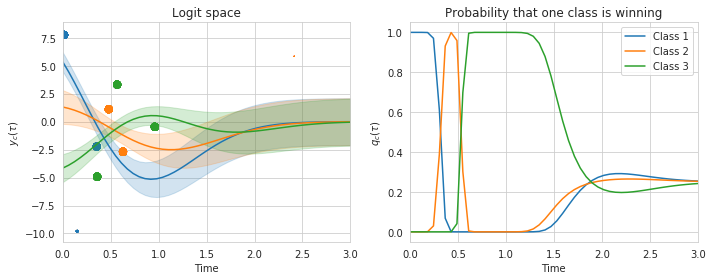

In [6]:
tf.reset_default_graph()
tf.set_random_seed(123)
model = GaussianProcess(n_classes=3, dim=32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(400):
        x, tx, y, ty, s = d.get_batch(50, 64)
        feed = { model.x: x, model.tx: tx, model.y: y, model.ty: ty, model.s: s }
        _, loss = sess.run([model.optimize, model.loss], feed)
        
        if (i + 1) % 100 == 0:
            print('Iteration: %d\tLoss: %.4f' % (i + 1, loss))
    
    x, tx, y, ty, s = d.get_batch(1, 64)

    M = 50
    x = np.tile(x, [M, 1])
    tx = np.tile(tx, [M, 1])
    y = np.tile(y, [M, 1])
    ty = np.tile(ty, [M, 1])
    s = np.tile(s, [M])
    
    ty[:,-1] = np.linspace(0, 3, M)
    
    feed = { model.x: x, model.tx: tx, model.y: y, model.ty: ty, model.s: s }
    mu, sigma, t_points, y_points, w_points = \
        sess.run([model.logits, model.logits_sigma, model.t_sample, model.y_sample, model.w], feed)
    
    p_win = []
    for i in range(M):
        p_w = np.ones(3)
        for j in range(3):
            for k in range(3):
                if k != j:
                    p_w[j] *= float(norm.cdf(0, loc=mu[i,-1,k] - mu[i,-1,j], scale=sigma[i,-1,k] + sigma[i,-1,j]))
        p_win.append(p_w)
    p_win = np.array(p_win)

    sigma = 2 * np.sqrt(sigma)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
    for i in range(3):
        color = 'C' + str(i)
        
        ax1.plot(ty[:,-1], mu[:,-1,i], color=color, label='Class ' + str(i+1))
        ax1.fill_between(ty[:,-1], (mu - sigma)[:,-1,i], (mu + sigma)[:,-1,i], alpha=0.2, color=color)
        ax1.scatter(t_points[:,-1,i,:], y_points[:,-1,i,:], s=w_points[:,-1,i,:] * 50, color=color)
        ax1.set_xlabel('Time')
        ax1.set_ylabel(r'$y_c(\tau)$')
        ax1.set_xlim([0, 3])
        ax1.set_title('Logit space')
        
        ax2.plot(ty[:,-1], p_win[:,i], label='Class ' + str(i+1), color=color)
        ax2.set_xlabel('Time')
        ax2.set_ylabel(r'$q_c(\tau)$')
        ax2.set_title('Probability that one class is winning')
        ax2.set_xlim([0, 3])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Dirichlet via a Function Decomposition (FD-Dir)

In [7]:
class Dirichlet:
    def __init__(self, n_classes, dim, lr=0.001, points=20, l2=1e-4, cell='gru'):
        self.n_classes = n_classes
        self.dim = dim
        self.n_gaussians = points
        self.cell = cell

        self.x = tf.placeholder(tf.int32, [None, None], 'x')
        self.tx = tf.placeholder(tf.float32, [None, None], 'tx')
        self.y = tf.placeholder(tf.int32, [None, None], 'y')
        self.ty = tf.placeholder(tf.float32, [None, None], 'ty')
        self.s = tf.placeholder(tf.int32, [None], 'sequence-length')

        self.h = self.LSTM(self.x, self.tx, self.s)
        self.h = tf.identity(self.h, name='hidden')
        self.log_alpha_t, self.pi, self.means, self.vars = self.Dirichlet(self.h, self.ty)
        self.log_alpha_t = tf.identity(self.log_alpha_t, name='logits')

        self.alpha_t = tf.exp(self.log_alpha_t, name='alpha_t')
        self.alpha0 = tf.reduce_sum(tf.exp(self.log_alpha_t), axis=-1, name='alpha_0')
        self.py = tf.nn.softmax(self.log_alpha_t, name='py')
        self.y_hat = tf.argmax(self.log_alpha_t, -1, name='y-hat')

        self.loss = self.get_loss()
        self.loss += tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name]) * l2
        self.loss = tf.identity(self.loss, name='loss')
        self.optimize = tf.train.AdamOptimizer(lr).minimize(self.loss, name='optimize')

    def LSTM(self, x, t, s, scope='lstm', reuse=tf.AUTO_REUSE):
        cell = tf.nn.rnn_cell.BasicRNNCell if self.cell == 'rnn' else tf.nn.rnn_cell.GRUCell
        with tf.variable_scope(scope, reuse=reuse):
            x = tf.one_hot(x, self.n_classes)
            t = tf.expand_dims(t, -1)
            h, _ = tf.nn.dynamic_rnn(cell(self.dim), tf.concat([x, t], -1), sequence_length=s, dtype=tf.float32)
        return h

    def Dirichlet(self, h, ty, scope='dirichlet', reuse=tf.AUTO_REUSE):
        with tf.variable_scope(scope, reuse=reuse):
            # Compute means and variances of gaussians
            means = tf.layers.dense(h, self.n_gaussians * self.n_classes, activation=tf.nn.sigmoid, kernel_initializer=tf.random_uniform_initializer, name='layer-means')
            means = tf.reshape(means, [-1, tf.shape(means)[1], self.n_classes, self.n_gaussians])
            vars = tf.layers.dense(h, self.n_gaussians * self.n_classes, activation=tf.nn.softplus, kernel_initializer=tf.random_uniform_initializer, name='layer-vars')
            vars = tf.reshape(vars, [-1, tf.shape(vars)[1], self.n_classes, self.n_gaussians])

            # Compute gaussians probabilities
            ty = tf.tile(tf.expand_dims(tf.tile(tf.expand_dims(ty, -1), [1, 1, self.n_classes]), -1), [1, 1, 1, self.n_gaussians])
            gaussians = tf.distributions.Normal(loc=means, scale=vars).prob(ty)

            # Compute log of alphas by combining gaussians
            unstacked = tf.keras.layers.Lambda(lambda x: tf.unstack(x, axis=-2), name='unstack-gaussians')(gaussians)
            dense_outputs = []
            dense_pis = []
            W_norm = {}
            for k, x in enumerate(unstacked):
                W_norm[k] = tf.layers.dense(h, self.n_gaussians, name='layer-weights-' + str(k))
                # W_norm = tf.layers.dense(h, self.n_gaussians, tf.nn.relu)
                # W_norm = tf.nn.softmax(W_norm)
                W_norm[k] = tf.expand_dims(W_norm[k], -2, name='W_norm-' + str(k))
                x = tf.expand_dims(x, -1, name='x')
                dense_outputs.append(tf.squeeze(tf.matmul(W_norm[k], x, name='gaussians-weighting-' + str(k)), [-1]))
                dense_pis.append(W_norm[k])
            log_alpha_t = tf.keras.layers.Lambda(lambda x: tf.concat(x, axis=-1), name='stack-alphas')(dense_outputs)
            pi = tf.keras.layers.Lambda(lambda x: tf.concat(x, axis=-2), name='stack-weights')(dense_pis)
            return log_alpha_t, pi, means, vars

    def get_loss(self):
        # Compute uncertain entropy
        dirichlet_expectation = tf.digamma(self.alpha_t) - tf.tile(tf.expand_dims(tf.digamma(self.alpha0), -1), [1, 1, self.n_classes])
        y = tf.cast(tf.one_hot(self.y, self.n_classes), tf.bool)
        self.loss_ent_unc = -tf.reduce_mean(tf.squeeze(tf.boolean_mask(dirichlet_expectation, y)))
        loss = self.loss_ent_unc

        # Regularization
        M = 5
        alpha = 1e-3
        beta = 1e-3
        ty = tf.tile(self.ty, [M, 1])
        x = tf.tile(self.x, [M, 1])
        t = tf.tile(self.tx, [M, 1])
        s = tf.tile(self.s, [M])

        t_sample = ty * tf.random_uniform(tf.shape(ty))

        h = self.LSTM(x, t, s)
        log_alpha_t_sample, _, _, _ = self.Dirichlet(h, t_sample)
        alpha_t_sample = tf.exp(log_alpha_t_sample)

        mean = tf.digamma(self.alpha_t) - tf.tile(tf.expand_dims(tf.digamma(self.alpha0), -1), [1, 1, self.n_classes])
        dist = tfp.Dirichlet(alpha_t_sample)
        var = dist.variance()
        mean_reg = tf.reduce_mean(mean ** 2)
        var_reg = tf.reduce_mean(((self.n_classes-1)/(self.n_classes**2 * (self.n_classes + 1)) - var) ** 2)

        loss += alpha * mean_reg + beta * var_reg

        return loss

Iteration: 100	Loss: 0.5827
Iteration: 200	Loss: 0.5492
Iteration: 300	Loss: 0.5004
Iteration: 400	Loss: 0.4298


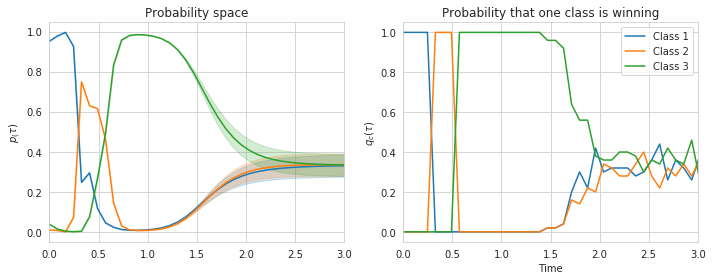

In [8]:
tf.reset_default_graph()
model = Dirichlet(n_classes=3, dim=32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(400):
        x, tx, y, ty, s = d.get_batch(50, 64)
        feed = { model.x: x, model.tx: tx, model.y: y, model.ty: ty, model.s: s }
        _, loss = sess.run([model.optimize, model.loss], feed)
        
        if (i + 1) % 100 == 0:
            print('Iteration: %d\tLoss: %.4f' % (i + 1, loss))
    
    x, tx, y, ty, s = d.get_batch(1, 64)

    M = 50
    x = np.tile(x, [M, 1])
    tx = np.tile(tx, [M, 1])
    y = np.tile(y, [M, 1])
    ty = np.tile(ty, [M, 1])
    s = np.tile(s, [M])
    
    ty[:,-1] = np.linspace(0, 4, M)
    
    feed = { model.x: x, model.tx: tx, model.y: y, model.ty: ty, model.s: s }
    alpha_t = sess.run(model.alpha_t, feed)

    mu = np.array([dirichlet.mean(alpha_t[i,-1,:]) for i in range(M)])
    var = np.array([dirichlet.var(alpha_t[i,-1,:]) for i in range(M)])
    
    p_win = []
    for i in range(M):
        p_w = np.zeros((M, 3))
        p_w[np.arange(M), np.argmax(dirichlet.rvs(alpha_t[i,-1,:], size=M), axis=-1)] = 1
        p_w = np.sum(p_w, axis=0) / np.sum(p_w)
        p_win.append(p_w)
    p_win = np.array(p_win)

    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
    for i in range(3):
        color = 'C' + str(i)

        ax1.plot(ty[:,-1], mu[:,i], color=color, label='Class ' + str(i+1))
        ax1.fill_between(ty[:,-1], (mu - var)[:,i], (mu + var)[:,i], alpha=0.2, color=color)
        ax1.set_ylabel(r'$p_(\tau)$')
        ax1.set_xlim([0, 3])
        ax1.set_title('Probability space')

        ax2.plot(ty[:,-1], p_win[:,i], label='Class ' + str(i+1), color=color)
        ax2.set_xlabel('Time')
        ax2.set_ylabel(r'$q_c(\tau)$')
        ax2.set_title('Probability that one class is winning')
        ax2.set_xlim([0, 3])
    plt.legend()
    plt.tight_layout()
    plt.show()